## Load libraries and Data

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import sys
sys.path.append("../src")
from extract_features import *
from visualize_audio import *
from prepare_data import *


constants

In [3]:
SAMPLING_RATING = 22050
FRAME_LENGTH_ENERGY = 2048  # 512
THRESHOLD_PERCENTAGE = 0.01  # percentage of max energy
MIN_SILENCE_DURATION = 1  # in seconds

# n_fft=512 # the window size
HOP_LENGTH = 512  # the number of samples between successive frames
SEGMENT_DURATION = 0.025  # in seceonds
SEGMENT_OVERLAP = 0.01  # in seceonds
N_MFCC = 13

## Preprocessing

### experimenting on some recording

In [4]:
audio1, SAMPLING_RATING = librosa.load("../data/raw/recordings/hindi1.mp3", sr=SAMPLING_RATING)
audio2, SAMPLING_RATING = librosa.load("../data/raw/recordings/hindi2.mp3", sr=SAMPLING_RATING)
audio3, SAMPLING_RATING = librosa.load("../data/raw/recordings/hindi3.mp3", sr=SAMPLING_RATING)

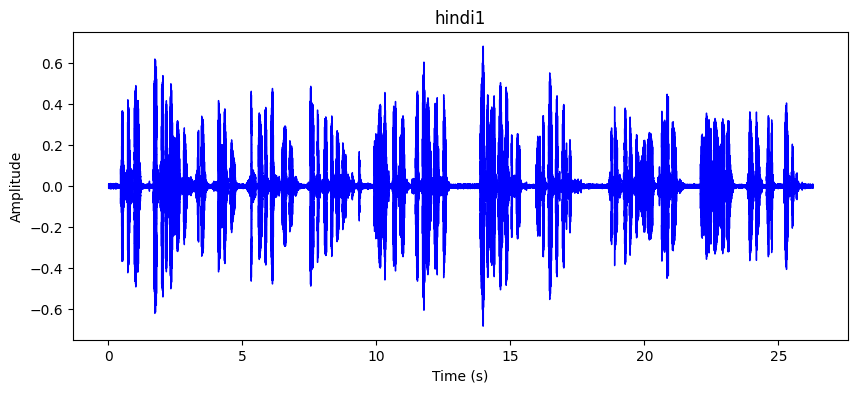

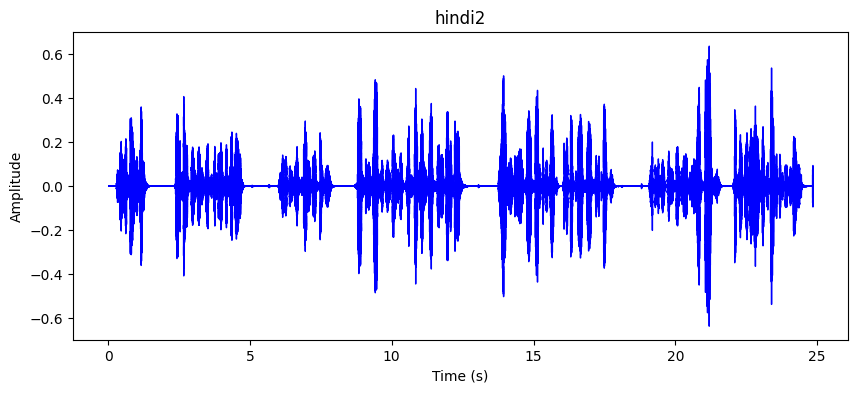

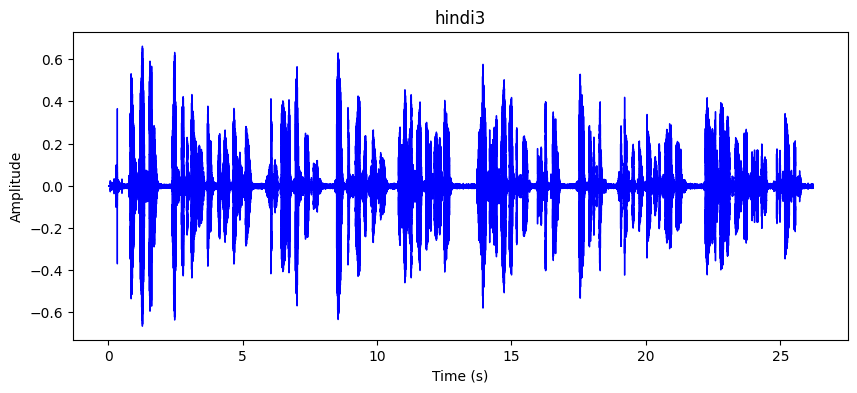

In [5]:
plot_audio(audio1, SAMPLING_RATING, title="hindi1")
plot_audio(audio2, SAMPLING_RATING, title="hindi2")
plot_audio(audio3, SAMPLING_RATING, title="hindi3")

In [6]:
energy = librosa.feature.rms(y=audio1)[0]
max_energy = max(energy)
threshold_energy = THRESHOLD_PERCENTAGE * max_energy
silent_segments = energy < threshold_energy
ratio = sum(silent_segments) / len(energy)
print("ratio of silent segments for hindi 1:", round(100 * ratio, 2), "%")

energy = librosa.feature.rms(y=audio2)[0]
max_energy = max(energy)
threshold_energy = THRESHOLD_PERCENTAGE * max_energy
silent_segments = energy < threshold_energy
ratio = sum(silent_segments) / len(energy)
print("ratio of silent segments for hindi 2:", round(100 * ratio, 2), "%")

energy = librosa.feature.rms(y=audio3)[0]
max_energy = max(energy)
threshold_energy = THRESHOLD_PERCENTAGE * max_energy
silent_segments = energy < threshold_energy
ratio = sum(silent_segments) / len(energy)
print("ratio of silent segments for hindi 3:", round(100 * ratio, 2), "%")

ratio of silent segments for hindi 1: 0.18 %
ratio of silent segments for hindi 2: 24.0 %
ratio of silent segments for hindi 3: 0.09 %


This indicates that silence segments sometimes takes a big portion of the audio and thus the need to trim it.

It is worth noting that we aren't trying to makr the ratio as close to 0% as possible as small "silence" frames/segments are part of the accent.

That's why we choose to only remove the silence segment when it is lasts more than 1 second.

Number of audible segments: 3


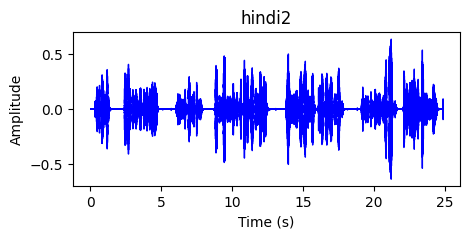

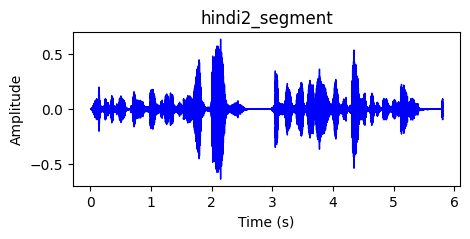

In [7]:
audible_segments = split_audio_by_silence(
    audio2,
    SAMPLING_RATING,
    threshold_percentage=THRESHOLD_PERCENTAGE,
    min_silence_duration=MIN_SILENCE_DURATION,
    frame_length_energy=FRAME_LENGTH_ENERGY,
    hop_length=HOP_LENGTH,
)
print("Number of audible segments:", len(audible_segments))
segment=audible_segments[2]
plot_audio(audio2, SAMPLING_RATING, title="hindi2", figsize=(5, 2))
plot_audio(segment, SAMPLING_RATING, title="hindi2_segment", figsize=(5, 2))

import soundfile as sf
sf.write("../data/processed/hindi2_segment.mp3", segment, SAMPLING_RATING)

segment audio

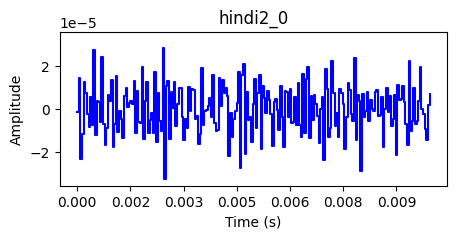

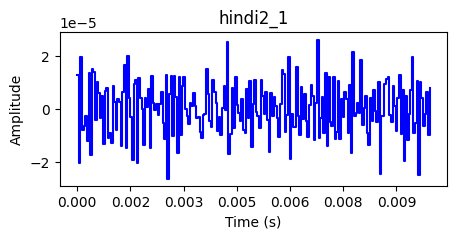

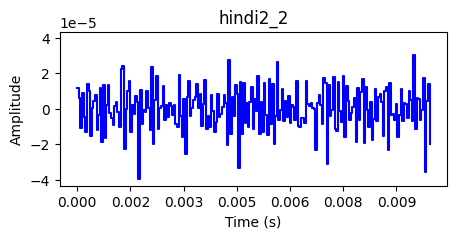

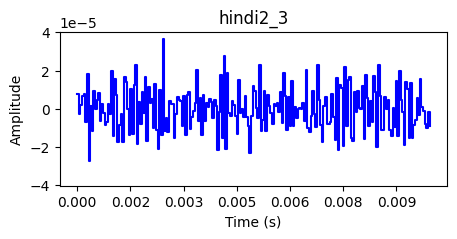

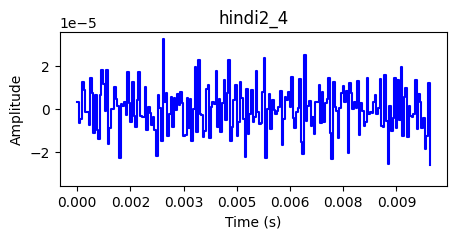

In [8]:
# Segment audio
segments = segment_audio(audio2, sr=SAMPLING_RATING, duration=0.01, overlap=0.001) # duration=10ms, overlap=1ms
for i, segment in enumerate(segments[:5]):
    plot_audio(segment, SAMPLING_RATING, title="hindi2_{}".format(i), figsize=(5, 2))

### Begin processign data

Load all audio files with the corresponding labels (accents) 

In [9]:
audio_data, labels = load_audio_files("../data/raw/recordings/", sr=SAMPLING_RATING)
unique_labels=set(labels)
print(f'there are {len(unique_labels)} unique labels: {unique_labels}')
print(f'there are {len(audio_data)} audio files')

there are 3 unique labels: {'spanish', 'japanese', 'hindi'}
there are 14 audio files


Visualize the number of recordings in each accent

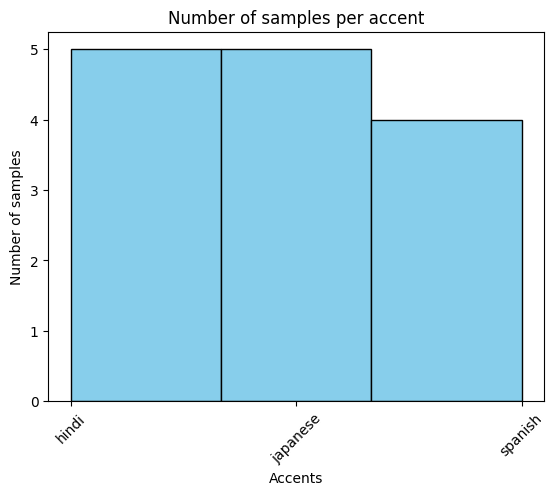

In [10]:
plt.hist(labels, bins=len(unique_labels), color='skyblue', edgecolor='black')
plt.xlabel('Accents')
plt.ylabel('Number of samples')
plt.title('Number of samples per accent')
plt.xticks(rotation=45)
plt.show()


Trim silence part and store all segments as individual audios with the corresponding labels

In [11]:
#trim silence part and store all segments as individual audios with the corresponding labels
audio_data_trimmed = []
labels_trimmed = []
for i, audio in enumerate(audio_data):
    audible_segments = split_audio_by_silence(
        audio,
        SAMPLING_RATING,
        threshold_percentage=THRESHOLD_PERCENTAGE,
        min_silence_duration=MIN_SILENCE_DURATION,
    )
    audio_data_trimmed.extend(audible_segments)
    labels_trimmed.extend([labels[i]] * len(audible_segments))
    for j, segment in enumerate(audible_segments):
        np.save(f"../data/processed/recordings/{labels[i]}_{i}_{j}.npy", segment)

False


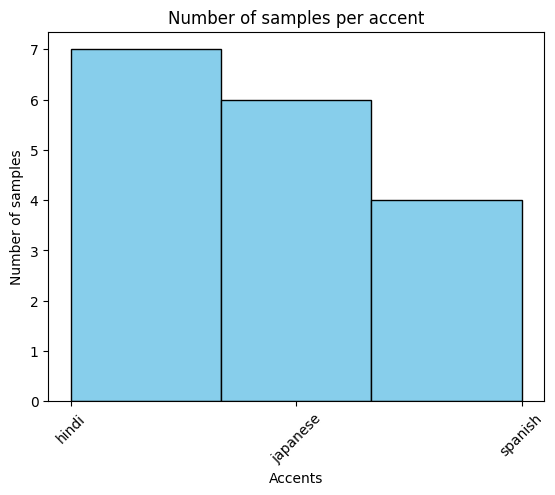

In [12]:
print(len(audio_data_trimmed)==len(audio_data))
plt.hist(labels_trimmed, bins=len(unique_labels), color='skyblue', edgecolor='black')
plt.xlabel('Accents')
plt.ylabel('Number of samples')
plt.title('Number of samples per accent')
plt.xticks(rotation=45)
plt.show()


segment audio data

In [13]:
# Segment audio data

# audio_data_segmented = []
# labels_segmented = []
# for i, audio in enumerate(audio_data_trimmed):
#     segments = segment_audio(
#         audio, SAMPLING_RATING, duration=SEGMENT_DURATION, overlap=SEGMENT_OVERLAP
#     )
#     audio_data_segmented.extend(segments)
#     labels_segmented.extend([labels_trimmed[i]] * len(segments))
#     # for j, segment in enumerate(segments):
#     #     np.save(f"../data/processed/segments/{labels_trimmed[i]}_{i}_{j}.npy", segment)

In [14]:
# print(f"there are {len(audio_data_segmented)} segments .")

### extract features

extract MFCCs

In [15]:
# extract MFCC features from trimmed audio data (not on segmented audio data because the function itself will split the audio data into segments)
mfccs = []
for audio in audio_data_trimmed:
    mfcc = compute_mfcc(
        audio, SAMPLING_RATING, n_mfcc=N_MFCC, duration=SEGMENT_DURATION, overlap=SEGMENT_OVERLAP
    )
    mfccs.append(mfcc)

In [87]:
print(f"len(mfccs): {len(mfccs)}")
print(f"num_segments for mfccs[0]: {mfccs[0].shape[1]}")
print(f"num_segments for mfccs[5]: {mfccs[5].shape[1]}")

len(mfccs): 17
mfccs[0].shape: (13, 3280)
num_segments for mfccs[0]: 3280
mfccs[0][0]: 2.8592796325683594


In [58]:
# we want to split the mfccs into segments with the corresponding labels

# Initialize lists to store segments and their corresponding labels
segmented_mfccs = []
segmented_labels = []

# Iterate over each audio
for i, mfcc in enumerate(mfccs):
    # Get the shape of MFCCs and label for the current audio
    mfcc_shape = mfcc.shape
    label = labels_trimmed[i]

    # Extract the number of segments and the number of frames per segment
    num_segments = mfcc.shape[1]  # Second dimension of the MFCC shape

    # Iterate over each segment in the current audio
    for j in range(num_segments):
        # Extract the MFCCs for the current segment
        mfcc_segment = mfccs[i][:, j]

        # Append the segment and its corresponding label to the lists
        segmented_mfccs.append(mfcc_segment)
        segmented_labels.append(label)

# Convert the lists to NumPy arrays
# segmented_mfccs = np.array(segmented_mfccs)
# segmented_labels = np.array(segmented_labels)

print(f"len(segmented_mfccs): {len(segmented_mfccs)}")
print(f"len(segmented_labels): {len(segmented_labels)}")
print(f"segmented_mfccs[0]: {len(segmented_mfccs[0])}")
print(f"segmented_labels[0]: {segmented_labels[0]}")

len(segmented_mfccs): 41846
len(segmented_labels): 41846
segmented_mfccs[0]: 13
segmented_labels[0]: hindi


Perform One-Hot Encoding labels

In [84]:
# Convert labels to numerical format using label encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(segmented_labels)

# Perform one-hot encoding
onehot_encoder = OneHotEncoder()
encoded_labels = encoded_labels.reshape(len(encoded_labels), 1)
onehot_labels = onehot_encoder.fit_transform(encoded_labels).toarray() # toarray() is  to convert the sparse matrix to a dense array

print(onehot_labels)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


## Storing data

In [86]:
# Save segmented MFCC features and one-hot encoded labels as NumPy arrays
np.save('../data/processed/segmented_mfccs.npy', segmented_mfccs)
np.save('../data/processed/onehot_labels.npy', onehot_labels)